In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download elysian01/yoga-pose-classification

100% 527M/528M [00:26<00:00, 22.3MB/s]
100% 528M/528M [00:26<00:00, 21.2MB/s]


In [ ]:
! unzip yoga-pose-classification.zip

Archive:  yoga-pose-classification.zip
  inflating: dataset/final_test/yoga_set1/1.jpg  
  inflating: dataset/final_test/yoga_set1/11.jpg  
  inflating: dataset/final_test/yoga_set1/3.jpg  
  inflating: dataset/final_test/yoga_set1/4.jpg  
  inflating: dataset/final_test/yoga_set1/5.jpg  
  inflating: dataset/final_test/yoga_set1/6.jpg  
  inflating: dataset/final_test/yoga_set1/7.jpg  
  inflating: dataset/final_test/yoga_set1/8.jpg  
  inflating: dataset/final_test/yoga_set1/9.jpg  
  inflating: dataset/final_test/yoga_set2/1.jpg  
  inflating: dataset/final_test/yoga_set2/10.jpg  
  inflating: dataset/final_test/yoga_set2/2.jpg  
  inflating: dataset/final_test/yoga_set2/3.jpg  
  inflating: dataset/final_test/yoga_set2/4.jpg  
  inflating: dataset/final_test/yoga_set2/5.jpg  
  inflating: dataset/final_test/yoga_set2/6.jpg  
  inflating: dataset/final_test/yoga_set2/7.jpg  
  inflating: dataset/final_test/yoga_set2/8.jpg  
  inflating: dataset/final_test/yoga_set2/9.jpg  
  inflati

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import math
from tensorflow import keras
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Activation

from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
%config Completer.use_jedi = False

In [ ]:
# GPU Configurations

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [ ]:
basedir = "./dataset/" # here below the train and validation data

In [ ]:
def removeCorruptedImages(path):
    for filename in os.listdir(path):
        try:
            img = Image.open(os.path.join(path,filename))
            img.verify() 
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            os.remove(os.path.join(path,filename))

In [ ]:
# Yoga Set 1
yoga_train_path = os.path.join("yoga_set1","train") # root for training
yoga_test_path = os.path.join("yoga_set1","test") # root for testing

# Yoga Set 2
yoga_train_path2 = os.path.join("yoga_set2","train") # root for training
yoga_test_path2 = os.path.join("yoga_set2","test") # root for testing



In [ ]:
traindir = os.path.join(basedir,yoga_train_path) 
validdir = os.path.join(basedir,yoga_test_path) 
traindir2 = os.path.join(basedir, yoga_train_path2) 
validdir2 = os.path.join(basedir, yoga_test_path2) 

In [ ]:
import os

print("changing the names of the images files for  yoga set 1 so it does not clash with the names of yoga set 2")

list_dirs = ["downdog","tree","warrior1"]

for i in list_dirs:
  # Define the path to the second folder
  folder_train1_path = os.path.join(traindir,i) 

  # Define the character to add to the filenames
  char1 = '1_'

  # Loop through the images in folder 1 and rename them
  for filename in os.listdir(folder_train1_path):
    os.rename(os.path.join(folder_train1_path, filename), os.path.join(folder_train1_path, char1 + filename))

for i in list_dirs:
  # Define the path to the second folder
  folder_test2_path = os.path.join(validdir,i) 

  # Define the character to add to the filenames
  char1 = '1_'

  # Loop through the images in folder 1 and rename them
  for filename in os.listdir(folder_train1_path):
    os.rename(os.path.join(folder_train1_path, filename), os.path.join(folder_train1_path, char1 + filename))

changing the names of the images files for  yoga set 1 so it does not clash with the names of yoga set 2


In [ ]:
import os

list_dirs = ["goddess","mountain","warrior2"]

for i in list_dirs:
  # Define the path to the second folder
  folder_train2_path = os.path.join(traindir2,i) 

  # Define the character to add to the filenames
  char1 = '2_'

  # Loop through the images in folder 1 and rename them
  for filename in os.listdir(folder_train1_path):
    os.rename(os.path.join(folder_train1_path, filename), os.path.join(folder_train1_path, char1 + filename))

for i in list_dirs:
  # Define the path to the second folder
  folder_train2_path = os.path.join(validdir2,i) 

  # Define the character to add to the filenames
  char1 = '2_'

  # Loop through the images in folder 1 and rename them
  for filename in os.listdir(folder_train1_path):
    os.rename(os.path.join(folder_train1_path, filename), os.path.join(folder_train1_path, char1 + filename))

In [ ]:
import shutil

merged_train_dir = os.path.join(basedir, "merged_train_dir")

# Create the merged directory if it doesn't exist
if not os.path.exists(merged_train_dir):
    os.makedirs(merged_train_dir)

# Merge the directories
for class_name in os.listdir(traindir):
    src = os.path.join(traindir, class_name)
    dst = os.path.join(merged_train_dir, class_name)
    shutil.copytree(src, dst)

for class_name in os.listdir(traindir2):
    src = os.path.join(traindir2, class_name)
    dst = os.path.join(merged_train_dir, class_name)
    shutil.copytree(src, dst)


In [ ]:
import shutil

merged_test_dir = os.path.join(basedir, "merged_test_dir")

# Create the merged directory if it doesn't exist
if not os.path.exists(merged_test_dir):
    os.makedirs(merged_test_dir)

# Merge the directories
for class_name in os.listdir(validdir):
    src = os.path.join(validdir, class_name)
    dst = os.path.join(merged_test_dir, class_name)
    shutil.copytree(src, dst)

for class_name in os.listdir(validdir2):
    src = os.path.join(validdir2, class_name)
    dst = os.path.join(merged_test_dir, class_name)
    shutil.copytree(src, dst)


In [ ]:
# Yoga Set 1
removeCorruptedImages(os.path.join(merged_train_dir,'tree'))
removeCorruptedImages(os.path.join(merged_train_dir,'downdog'))
removeCorruptedImages(os.path.join(merged_train_dir,'warrior1'))

removeCorruptedImages(os.path.join(merged_test_dir,'tree'))
removeCorruptedImages(os.path.join(merged_test_dir,'downdog'))
removeCorruptedImages(os.path.join(merged_test_dir,'warrior1'))


# Yoga Set 2
removeCorruptedImages(os.path.join(merged_train_dir,'goddess'))
removeCorruptedImages(os.path.join(merged_train_dir,'mountain'))
removeCorruptedImages(os.path.join(merged_train_dir,'warrior2'))

removeCorruptedImages(os.path.join(merged_test_dir,'goddess'))
removeCorruptedImages(os.path.join(merged_test_dir,'mountain'))
removeCorruptedImages(os.path.join(merged_test_dir,'warrior2')) 

In [ ]:
train_datagen=ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen=ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [ ]:
batch_size=8
print("For Training: ")
train_datagen = train_datagen.flow_from_directory(
                  directory = merged_train_dir,
                  target_size=(224,224),
                  batch_size=batch_size,
                  shuffle=True,
                  color_mode="rgb",
                  class_mode='categorical')

print("\nFor Testing: ")
val_datagen = test_datagen.flow_from_directory(
                directory = merged_test_dir,
                target_size=(224,224),
                batch_size=batch_size,
                shuffle=True,
                color_mode="rgb",
                class_mode='categorical')

For Training: 
Found 2496 images belonging to 6 classes.

For Testing: 
Found 389 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

output_neurons = 6

model = Sequential()
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(output_neurons))
model.add(Activation('softmax'))


model = Model(inputs=base_model.input, outputs=model(base_model.output))


optimizers = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
losss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
model.compile(loss=losss,
             optimizer=optimizers,
              metrics=['accuracy'])

model.summary()


94765736/94765736 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
class ConvolutionCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>=0.99 and logs.get('val_accuracy') >=0.92):
                print("Reached greater than 99.0% accuracy so cancelling training!")
                self.model.stop_training = True
                
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.001, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint("./checkpoints_models/pose_classification_model_weights2.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

convolutionCallback = ConvolutionCallback()
callbacks = [PlotLossesKerasTF(), checkpoint,reduce_lr, convolutionCallback]

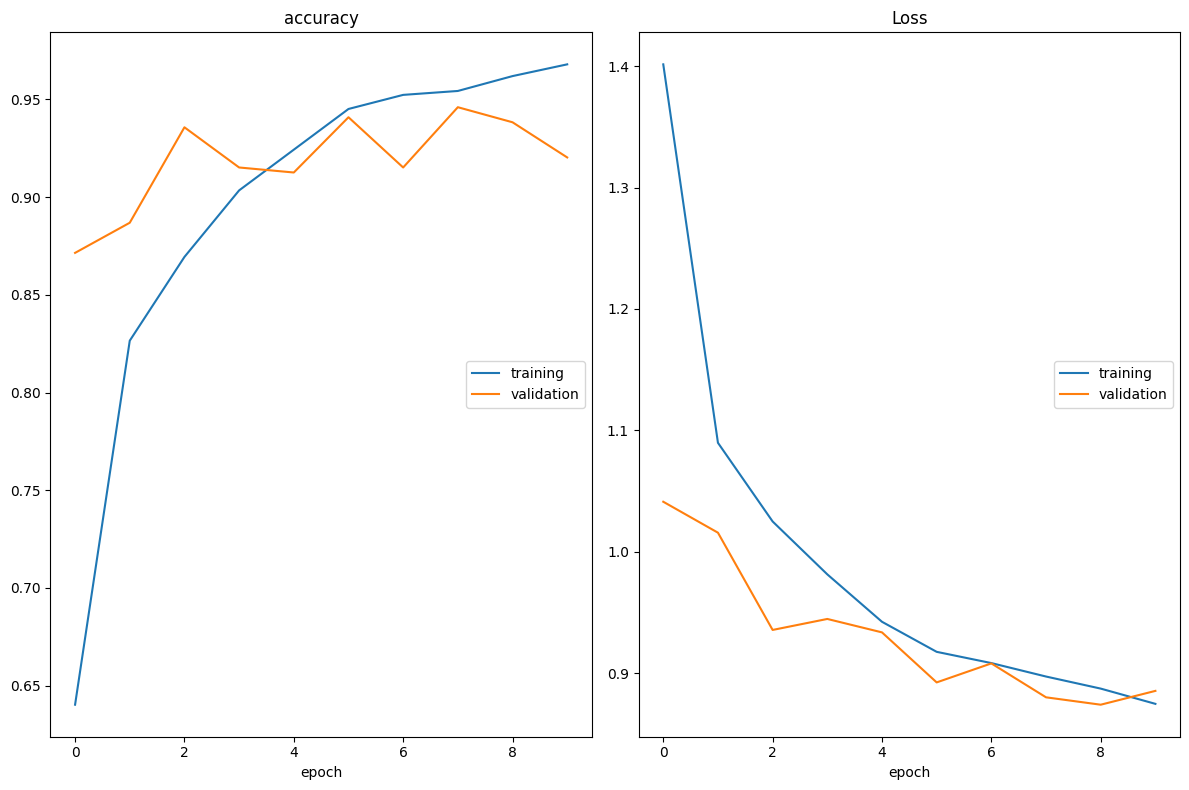

accuracy
	training         	 (min:    0.640, max:    0.968, cur:    0.968)
	validation       	 (min:    0.871, max:    0.946, cur:    0.920)
Loss
	training         	 (min:    0.875, max:    1.401, cur:    0.875)
	validation       	 (min:    0.874, max:    1.041, cur:    0.885)

Epoch 10: saving model to ./checkpoints_models/pose_classification_model_weights2.h5
312/312 [==============================] - 95s 305ms/step - loss: 0.8748 - accuracy: 0.9679 - val_loss: 0.8855 - val_accuracy: 0.9203 - lr: 1.0000e-04


In [ ]:
# epoch_for_model2 = 5
BATCH_SIZE = 16

history = model.fit(train_datagen, epochs=10, validation_data = val_datagen, callbacks=callbacks)

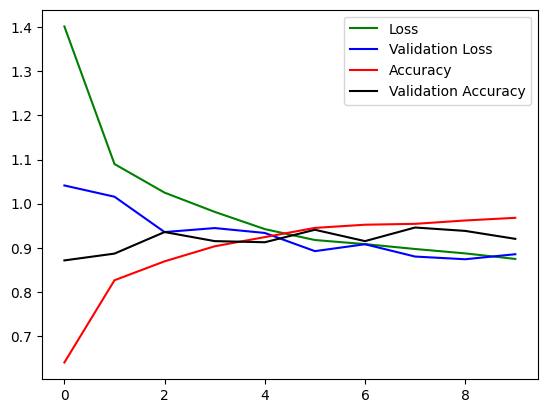

In [ ]:
plt.figure(0)
plt.plot(history.history['loss'],'g', label="Loss")
plt.plot(history.history['val_loss'],'b',label="Validation Loss")
plt.plot(history.history['accuracy'],'r', label="Accuracy")
plt.plot(history.history['val_accuracy'],'black', label="Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
yoga_classification_model_save_path = "./final_models/H5_Models/Yoga_classification.h5"
model.save(yoga_classification_model_save_path)

In [ ]:
loaded_model = tf.keras.models.load_model('./final_models/H5_Models/Yoga_classification.h5')
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
## TFLite Import

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

yoga_final_model_name = "Yoga_Set1_TFLite_Model.tflite"
# yoga_final_model_name = "Yoga_Set2_TFLite_Model.tflite"

tflite_model_name = yoga_final_model_name
open(tflite_model_name,"wb").write(tflite_model)

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')
    
convert_bytes(get_file_size(tflite_model_name),"MB")

File size: 138.617 Megabytes


In [ ]:
model.evaluate(val_datagen)   

49/49 [==============================] - 12s 247ms/step - loss: 0.8820 - accuracy: 0.9280


[0.8819864988327026, 0.9280205368995667]

In [ ]:
yoga_labels = {0:"downdog",1:"goddess",2:"mountain", 3:"tree", 4:"warrior1", 5:"warrior2"}

In [ ]:
current_file_name = "/content/dataset/final_test/yoga_set1/11.jpg"
new_file_name = "/content/dataset/final_test/yoga_set1/2.jpg"
os.rename(current_file_name, new_file_name)

Enter a number between 1 or 2 (1 if you would like to test a picture of either downdog,tree, warrior1  OR 2 for goddess,mountain,warrior2) : 2
Enter Image Name (from 1-9) : 9
1/1 [==============================] - 0s 23ms/step


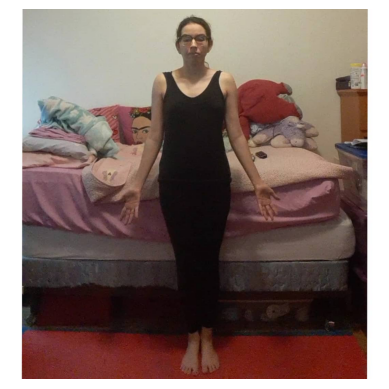

Class Predictions:  [[3.8343722e-03 1.0097140e-02 9.7922540e-01 3.9369971e-03 9.3671062e-04
  1.9693191e-03]]

Prediction is:  mountain


In [ ]:
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

# predicting images
path1 = input("Enter a number between 1 or 2 (1 if you would like to test a picture of either downdog,tree, warrior1  OR 2 for goddess,mountain,warrior2) : ")
path2 = input("Enter Image Name (from 1-9) : ")
path = "./dataset/final_test/yoga_set" + path1 +"/" + path2+ ".jpg"

img = image.load_img(path, target_size=(224, 224))
x = image.img_to_array(img)
#print(x/255)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = loaded_model.predict(images)

plt.axis("Off")
img = mpimg.imread(path)
plt.imshow(img)
plt.show()

print("Class Predictions: ",classes)
pred_index = np.argmax(classes)
print("\nPrediction is: ", yoga_labels[pred_index])